In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def calculate_reference_areas(xmin, xmax, ymin, ymax, i_max, s_values, num_runs):
    reference_areas = np.zeros((len(s_values), num_runs))
    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs}")
        np.random.seed()
        for idx, s in enumerate(s_values):
            reference_s = s
            reference_i_max = i_max
            reference_area = 0.0
            for _ in range(reference_s):
                x = np.random.uniform(xmin, xmax)
                y = np.random.uniform(ymin, ymax)
                c = complex(x, y)
                z = c
                for _ in range(reference_i_max):
                    if abs(z) > 2.0:
                        break
                    z = z * z + c
                else:
                    reference_area += 1
            reference_area = (reference_area / reference_s) * (xmax - xmin) * (ymax - ymin)
            reference_areas[idx, run] = reference_area
            print(f"Reference Area for Run {run + 1}: {reference_area}, s: {s}")
    return reference_areas

In [3]:
# Define the weighting functions

# Higher weight near the boundary
def weighting_function(x, y, a, xmin, xmax, ymin, ymax):
    distance_to_boundary = np.sqrt(x**2 + y**2)
    return np.exp(-0.1 * distance_to_boundary)

# Quadratic weighting function
def gaussian_weighting(x, y, a, xmin, xmax, ymin, ymax):
    # Calculate the maximum distance from the origin in the rectangular region
    max_distance = np.sqrt(max((xmax - xmin)**2, (ymax - ymin)**2))
    # Quadratic weighting function
    return np.exp(-a * (x**2 + y**2) / max_distance**2)

# Radial Basis Function (RBF) Weighting Function
def rbf_weighting(x, y, a, xmin, xmax, ymin, ymax):
    # Calculate the maximum distance from the origin in the rectangular region
    max_distance = np.sqrt(max((xmax - xmin)**2, (ymax - ymin)**2))
    # RBF weighting function
    return np.exp(-a * np.sqrt((x - (xmin + xmax) / 2)**2 + (y - (ymin + ymax) / 2)**2) / max_distance)

In [4]:
def calculate_area_estimations_with_importance_sampling(xmin, xmax, ymin, ymax, i_max, s_values, num_runs, total_area, weighting_function):
    area_estimations_sum = np.zeros((i_max, len(s_values), num_runs))
    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs}")
        np.random.seed()
        for idx, s in enumerate(s_values):
            for j in range(1, i_max + 1):
                AM = 0.0
                for _ in range(s):
                    # Sample according to the weighting function
                    x = np.random.uniform(xmin, xmax)
                    y = np.random.uniform(ymin, ymax)
                    weight = weighting_function(x, y, a, xmin, xmax, ymin, ymax)

                    c = complex(x, y)
                    z = c
                    for _ in range(j):
                        if abs(z) > 2.0:
                            break
                        z = z * z + c
                    else:
                        AM += weight
                AM = (AM / s) * total_area[idx]
                area_estimations_sum[j - 1, idx, run] += AM
    return area_estimations_sum

In [5]:
# Set the parameters
xmin, xmax, ymin, ymax = -2.0, 1.0, -1.5, 1.5
i_max = 100
s_values = [200, 400, 600, 800, 1000]
num_runs = 1
total_area = np.ones(len(s_values)) * (xmax - xmin) * (ymax - ymin)

# Calculate the maximum distance from the origin in the rectangular region; used in quadratic weighting
max_distance = np.sqrt(max((xmax - xmin)**2, (ymax - ymin)**2))

# Adjust the a value based on the desired spread of influence; used in quadratic weighting
a = 1.0 / (2 * max_distance)

In [6]:
# Calculate area estimations with importance sampling using the quadratic weighting function
area_estimations_edge = calculate_area_estimations_with_importance_sampling(xmin, xmax, ymin, ymax, i_max, s_values, num_runs, total_area, weighting_function)

# Calculate area estimations with importance sampling using the quadratic weighting function
area_estimations_quad = calculate_area_estimations_with_importance_sampling(xmin, xmax, ymin, ymax, i_max, s_values, num_runs, total_area, gaussian_weighting)

# Calculate area estimations with importance sampling using the quadratic weighting function
area_estimations_rbf = calculate_area_estimations_with_importance_sampling(xmin, xmax, ymin, ymax, i_max, s_values, num_runs, total_area, rbf_weighting)


Run 1/1
Run 1/1
Run 1/1


In [7]:
# Calculate reference areas
reference_areas = calculate_reference_areas(xmin, xmax, ymin, ymax, i_max, s_values, num_runs)

# Calculate the reference area averages for each 's' value
reference_areas_avg = np.mean(reference_areas, axis=1)
print(reference_areas_avg)


Run 1/1
Reference Area for Run 1: 1.845, s: 200
Reference Area for Run 1: 1.755, s: 400
Reference Area for Run 1: 1.5, s: 600
Reference Area for Run 1: 1.5075000000000003, s: 800
Reference Area for Run 1: 1.6560000000000001, s: 1000
[1.845  1.755  1.5    1.5075 1.656 ]


In [8]:
reference_areas_avg.shape

(5,)

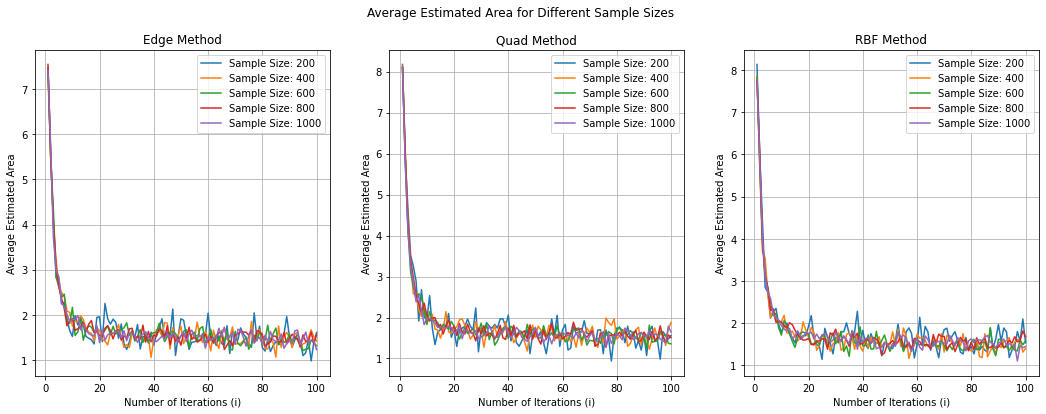

In [9]:
# Calculate the average estimated area for each sample size
average_area_edge = np.mean(area_estimations_edge, axis=2)
average_area_quad = np.mean(area_estimations_quad, axis=2)
average_area_rbf = np.mean(area_estimations_rbf, axis=2)

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the estimated area for different sample sizes in each subplot
for idx, s in enumerate(s_values):
    axes[0].plot(range(1, i_max + 1), average_area_edge[:, idx], label=f'Sample Size: {s}')
    axes[1].plot(range(1, i_max + 1), average_area_quad[:, idx], label=f'Sample Size: {s}')
    axes[2].plot(range(1, i_max + 1), average_area_rbf[:, idx], label=f'Sample Size: {s}')

# Set common labels and title
for ax in axes:
    ax.set_xlabel('Number of Iterations (i)')
    ax.set_ylabel('Average Estimated Area')
    ax.legend()
    ax.grid()

# Set individual titles
axes[0].set_title('Edge Method')
axes[1].set_title('Quad Method')
axes[2].set_title('RBF Method')

plt.suptitle('Average Estimated Area for Different Sample Sizes')
plt.show()

In [10]:
np.info(average_area_edge)

class:  ndarray
shape:  (100, 5)
strides:  (40, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f940b38ca00
byteorder:  little
byteswap:  False
type: float64


In [11]:
np.info(reference_areas_avg)

class:  ndarray
shape:  (5,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x7f94121f9db0
byteorder:  little
byteswap:  False
type: float64


# Absolute Error

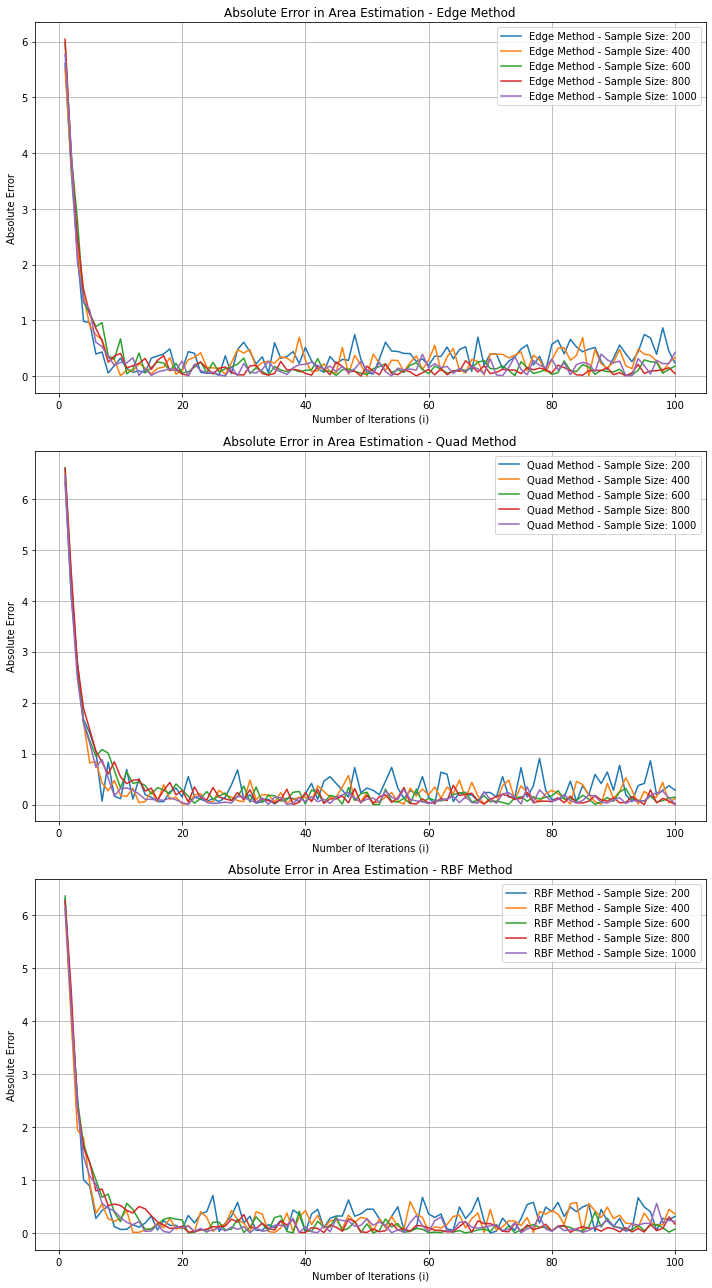

In [13]:
# Calculate the absolute error for each method
error_edge = np.abs(average_area_edge - reference_areas_avg)
error_quad = np.abs(average_area_quad - reference_areas_avg)
error_rbf = np.abs(average_area_rbf - reference_areas_avg)

# Sample sizes
s_values = [200, 400, 600, 800, 1000]

# Plotting the absolute error
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot for Edge Method
for idx, s in enumerate(s_values):
    axes[0].plot(range(1, i_max + 1), error_edge[:, idx], label=f'Edge Method - Sample Size: {s}')
axes[0].set_xlabel('Number of Iterations (i)')
axes[0].set_ylabel('Absolute Error')
axes[0].set_title('Absolute Error in Area Estimation - Edge Method')
axes[0].legend()
axes[0].grid()

# Plot for Quad Method
for idx, s in enumerate(s_values):
    axes[1].plot(range(1, i_max + 1), error_quad[:, idx], label=f'Quad Method - Sample Size: {s}')
axes[1].set_xlabel('Number of Iterations (i)')
axes[1].set_ylabel('Absolute Error')
axes[1].set_title('Absolute Error in Area Estimation - Quad Method')
axes[1].legend()
axes[1].grid()

# Plot for RBF Method
for idx, s in enumerate(s_values):
    axes[2].plot(range(1, i_max + 1), error_rbf[:, idx], label=f'RBF Method - Sample Size: {s}')
axes[2].set_xlabel('Number of Iterations (i)')
axes[2].set_ylabel('Absolute Error')
axes[2].set_title('Absolute Error in Area Estimation - RBF Method')
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()